<a href="https://colab.research.google.com/github/FedericoRaschiatore0123/Vision_and_Perception/blob/main/Emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Emotion Recognition
In this notebook we implemented our implementation of the emotion recognition for classify emotion.
We used the FER2013 Dataset and implemented the paper "PAtt-Lite: Lightweight Patch and Attention MobileNet for Challenging Facial Expression Recognition".

The structure of the model is the following: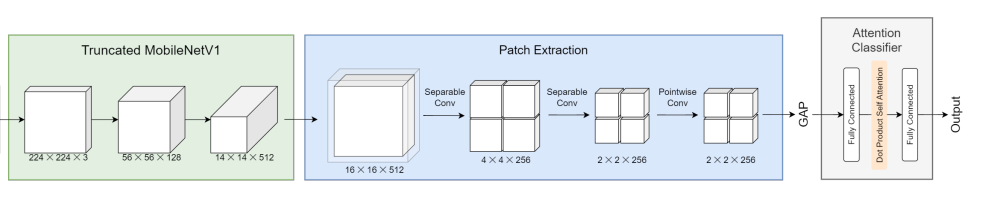

We implemented the following steps:


1.   We imported the dataset from our repository on github
2.   We used the truncated pretrained MobileNetV2 to extract features from the image
3.   We implemented a patch_extraction composed by 2 Separable convolutional layers and a Pointwise convolutional layer
4.   We used a ViT for the image classification





#References:


*   PAtt-Lite:    https://arxiv.org/pdf/2306.09626v1.pdf
*   FER2013:     https://paperswithcode.com/dataset/fer2013
*   MobileNetV2:    https://arxiv.org/pdf/1801.04381.pdf
*   ViT:     https://arxiv.org/pdf/2010.11929.pdf





FER2013 is introduced during the FER challenge
hosted on Kaggle. It is a database collected through the
Google image search API, with nearly 36,000 sample images
included. The sample images are annotated with 7 basic
expression labels, i.e., Angry, Disgust, Fear, Happy, Neutral,
Sad, and Surprise, by 1 tagger. Compared to RAF-DB, this
is a relatively more challenging database, as some of the
samples are incorrectly labeled and some are without a face

##Import

In this section we imported all the libraries.
We decided to use the pytorch lightning framework to simplify the training and the test

In [1]:
!pip install pytorch_lightning --quiet
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 664.4 kB/s eta 0:00:00


In [2]:
#!rm -r Vision_and_Perception
#!git clone https://github.com/spenceryee/CS229
#%cd Vision_and_Perception

In [3]:
!rm -r Vision_and_Perception
!git clone https://github.com/FedericoRaschiatore0123/Vision_and_Perception
%cd Vision_and_Perception

rm: cannot remove 'Vision_and_Perception': No such file or directory
Cloning into 'Vision_and_Perception'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (18/18), 46.66 MiB | 17.06 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/Vision_and_Perception


In [4]:
!unzip Train_1.zip -d train
!unzip Train_2.zip -d train
!unzip Train_3.zip -d train
!unzip test.zip -d test

Output streaming troncato alle ultime 5000 righe.
 extracting: test/test/happy/PrivateTest_22108748.jpg  
 extracting: test/test/happy/PrivateTest_22154496.jpg  
 extracting: test/test/happy/PrivateTest_2260082.jpg  
 extracting: test/test/happy/PrivateTest_22689070.jpg  
 extracting: test/test/happy/PrivateTest_22929697.jpg  
 extracting: test/test/happy/PrivateTest_22938435.jpg  
 extracting: test/test/happy/PrivateTest_22979298.jpg  
 extracting: test/test/happy/PrivateTest_2309763.jpg  
 extracting: test/test/happy/PrivateTest_23250597.jpg  
 extracting: test/test/happy/PrivateTest_23282756.jpg  
 extracting: test/test/happy/PrivateTest_23344981.jpg  
 extracting: test/test/happy/PrivateTest_23400117.jpg  
 extracting: test/test/happy/PrivateTest_2352334.jpg  
 extracting: test/test/happy/PrivateTest_23574753.jpg  
 extracting: test/test/happy/PrivateTest_23578691.jpg  
 extracting: test/test/happy/PrivateTest_23631554.jpg  
 extracting: test/test/happy/PrivateTest_23782289.jpg  
 

In [31]:
import os
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random
import pytorch_lightning as pl
from torchvision import datasets, transforms
from re import X
import torch as t

BATCH_SIZE=128

device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [6]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images.shape)
        print(labels)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break


In [32]:
# Specifica il percorso del tuo dataset
train_path = "../Vision_and_Perception/train"
test_path = "../Vision_and_Perception/test/test"
# Data augmentation
transformation = tt.Compose([ tt.Resize((224, 224)),
                              tt.ToTensor(),
                              tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                              #tt.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.2),
                              tt.RandomHorizontalFlip(),
                              tt.RandomRotation(30),
                         ])

# Carica il dataset
train_dataset = datasets.ImageFolder(root=train_path, transform=transformation)
test_dataset = datasets.ImageFolder(root=test_path, transform=transformation)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([64, 3, 224, 224])
tensor([3, 3, 5, 3, 5, 3, 3, 3, 5, 4, 5, 6, 0, 5, 2, 4, 4, 4, 6, 2, 5, 2, 4, 3,
        5, 4, 5, 4, 4, 3, 4, 3, 0, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 6, 0, 0, 0,
        2, 2, 0, 4, 5, 5, 2, 3, 3, 5, 3, 5, 6, 4, 6, 3])
449


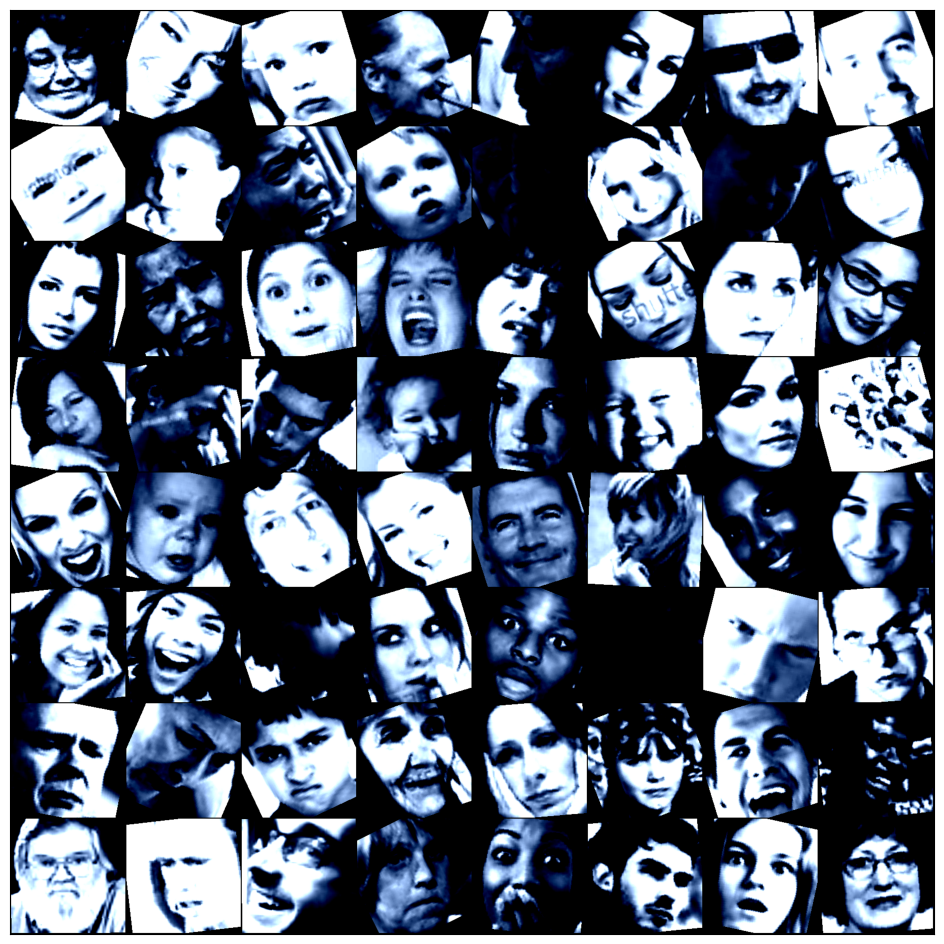

In [8]:
show_batch(train_dataloader)
print(len(train_dataloader))

## Feature extraction

In this section we implemented the feature extraction using the MobileNetV2 truncated to remove the fully connected layers.
We also used the PatchExtractionBlock to pass from a dimensionality of 14x14x96 to 2x2x42.


To do this we used 2 Separable Convolution Layers and a Pointwise Convolution Layer

In [9]:
import torch
from torchvision import models, transforms
from PIL import Image

class feature_extraction(nn.Module):
  def __init__(self):
    super().__init__()
    # Carica il modello MobileNetV1 pre-addestrato senza i layer fully connected
    model = models.mobilenet_v2(pretrained=True).features
    self.mod = nn.Sequential(*list(model.children())[:-5]).to(device)

    #model.eval()
  def forward(self, batch):
    image =  batch
    image = image.to(device)
    # Estrae le feature
    with torch.no_grad():
      feature = self.mod(image)

    return feature


# ViT

In [28]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor
from einops import repeat


class PatchEmbedding(pl.LightningModule):
    def __init__(self, in_channels, patch_size = 1,  emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.feature_extraction = feature_extraction()

        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)
        )

        self.linear= nn.Linear(patch_size * patch_size * in_channels, emb_size).to(device)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=5,  padding=1, stride = 2),
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, groups=in_channels, stride = 2),
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, emb_size, kernel_size=1),
        )


    def forward(self, batch):
        x , label = batch
        x = self.feature_extraction(x)
        x = self.conv(x)
        x = self.projection(x)
        #x = self.linear(x)


        return x , label


In [12]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn=fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


def accuracy(predicted_output, correct_output):

    real_output=[]
    num_correct_answers=0
    for i in range(len(predicted_output)):

        index = torch.argmax(predicted_output[i])

        if index == correct_output[i]:
            num_correct_answers += 1

    return num_correct_answers / len(predicted_output)


In [13]:
class Attention(pl.LightningModule):
  def __init__(self, emb_dim, num_heads):
    super(Attention, self).__init__()
    self.emb_dim=emb_dim
    self.num_heads = num_heads

    self.attention = nn.MultiheadAttention(self.emb_dim, self.num_heads, dropout=0.1)

    self.q = nn.Linear(emb_dim, emb_dim)
    self.k = nn.Linear(emb_dim, emb_dim)
    self.v = nn.Linear(emb_dim, emb_dim)

  def forward(self, x):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)
    attention, attention_weights = self.attention(q, k, v)
    return attention

In [33]:
class ViT(pl.LightningModule):
  def __init__(self, emb_dim, hidden_dim, out_dim, channels, input_channels=96, output_channels=48, patch_size = 7,  n_layers = 4,  img_size=48, dropout=0.1, num_heads = 8):
    super(ViT, self).__init__()
    self.emb_dim = emb_dim
    self.num_heads = num_heads
    self.hidden_dim = hidden_dim
    self.dropout = dropout
    self.channels = channels
    self.img_width = img_size
    self.img_height = img_size
    self.n_layers = n_layers

    self.patch_embedding = PatchEmbedding(input_channels, emb_size = emb_dim)

    #self.patch_extraction = PatchExtractionBlock(input_channels, output_channels)

    # Learnable params
    num_patches = (img_size // patch_size) ** 2
    self.positional_emb = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))
    self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))

    self.layers = nn.ModuleList([])
    block = nn.Sequential(

        Residual(PreNorm(emb_dim, Attention(emb_dim, num_heads))),

        Residual(PreNorm(emb_dim, nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                                nn.LeakyReLU(),
                                                nn.Dropout(dropout),
                                                nn.Linear(hidden_dim, emb_dim),
                                                nn.Dropout(dropout)
                                            )))
    )
    self.layers=block

    self.classification_head = nn.Sequential(nn.LayerNorm(emb_dim*5), nn.Linear(emb_dim*5, out_dim))
    self.softmax = nn.Softmax(dim=1)
    self.feature_extraction = feature_extraction()
    self.projection = nn.Sequential(
            Rearrange('b h p -> b (h p)')
        )

  def forward(self, batch):
      #images = self.patch_extraction(images)
      x , labels= self.patch_embedding(batch)
      b, n, _ = x.shape

      # Add cls token to inputs
      cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
      x = torch.cat([cls_tokens, x], dim=1)
      x += self.positional_emb[:, :(n+1)]

      x = self.layers(x)
      x = self.projection(x)
      return self.classification_head(x[:, :]), labels


  def training_step(self, batch, batch_idx):
        output, labels = self(batch)
        Loss = nn.CrossEntropyLoss()
        #labels = labels.unsqueeze(1)
        #Loss = nn.MSELoss()
        #loss = Loss(torch.argmax(output, dim=1), labels.float())
        loss = Loss(output, labels)
        #print(output)
        #print( torch.argmax(output, dim=1),labels)
        losses.append(loss.cpu().detach().numpy())
        print("train_loss", loss)
        return loss

  def validation_step(self, batch, batch_idx):
      output, labels = self(batch)

      acc_val.append(accuracy(output, labels))
      return acc_val

  def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
      return optimizer

  def test_step(self, batch, batch_idx):
      output, labels = self(batch)

      acc.append(accuracy(output, labels))
      return acc
acc_val=[]
acc=[]
losses = []
model = ViT(128, 512, 7, 48)

In [34]:
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model, train_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type               | Params
-----------------------------------------------------------
0 | patch_embedding     | PatchEmbedding     | 817 K 
1 | layers              | Sequential         | 247 K 
2 | classification_head | Sequential         | 5.8 K 
3 | softmax             | Softmax            | 0     
4 | feature_extraction  | feature_extraction | 542 K 
5 | projection          | Sequential         | 0     
  | other params        | n/a                | 4.9 K 
-----------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(2.2740, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(2.1183, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(2.1316, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(2.0334, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.9723, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.9097, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.8926, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.8689, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.8742, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.8117, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.8397, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.8305, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.9204, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)
train_

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


train_loss tensor(1.2157, device='cuda:0', grad_fn=<NllLossBackward0>)


Con 8 heads e 4 layers abbiamo un accuracy sul validate di: 35% sul test di: 53%  in 5 epochs

Con 4 heads e 2 layers abbiamo un'accuracy sul validate di:  sul test di:   in 5 epochs

In [35]:
model_path = "./model.pth"
torch.save(model.state_dict(), model_path)

In [36]:
trainer.validate(model,train_dataloader)
print(sum(acc_val)/len(acc_val))
#plt.plot(losses)
#plt.grid()
#plt.show()

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

0.5213203828828828


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

0.5135416666666667


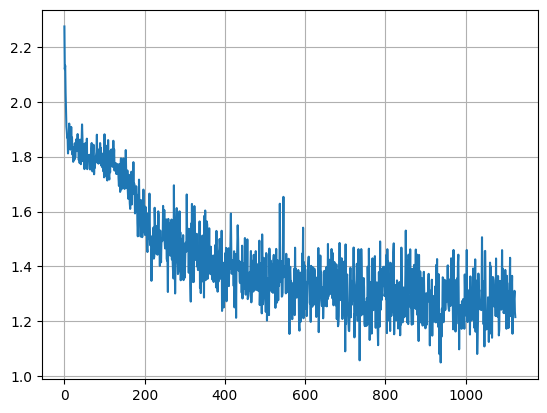

In [37]:
trainer.test(model,test_dataloader)
print(sum(acc)/len(acc))
plt.plot(losses)
plt.grid()
plt.show()

##Comparison

In [38]:
class MobileNetV2(pl.LightningModule):
  def __init__(self):
    super(MobileNetV2, self).__init__()
    self.model = models.mobilenet_v2(pretrained=True)

  def forward(self, batch):
      x, label = batch
      result = self.model(x)
      return result


  def training_step(self, batch, batch_idx):
        output, labels = self(batch)
        Loss = nn.CrossEntropyLoss()

        loss = Loss(output, labels)

        losses2.append(loss.cpu().detach().numpy())
        print("train_loss", loss)
        return loss

  def validation_step(self, batch, batch_idx):
      output, labels = self(batch)

      acc_val2.append(accuracy(output, labels))
      return acc_val2

  def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
      return optimizer

  def test_step(self, batch, batch_idx):
      output, labels = self(batch)

      acc2.append(accuracy(output, labels))
      return acc2
acc_val2=[]
acc2=[]
losses2 = []
model2 = MobileNetV2()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
trainer2 = pl.Trainer()
trainer2.test(model2, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list of [Tensor, Tensor]!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list of [Tensor, Tensor]!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
